<a href="https://colab.research.google.com/github/simon-mellergaard/RL/blob/main/Exercises/05_bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
### Useful presteps

## debugging (set off when finish coding)
# Use ipdb.set_trace() to set breakpoint
# Useful ipdb commands
    # p <variable>: Print the value of a variable.
    # n: Execute the next line of code.
    # c: Continue execution until the next breakpoint or the end of the program.
    # q: Quit the debugger.
# %debug # Can be run in a code cell after the cell with error
# !pip install ipdb
# import ipdb
# %pdb on
# %pdb off

## Missing packages
!pip install dfply

import random
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd
from plotnine import ggplot, aes, geom_line, labs, theme
from dfply import *

# Multi-armed bandits  

This notebook consider the k-armed bandit problem which is a sequential decision problem with one state and $k$ actions.

Imagine you are facing a wall with slot machines, and each one pays out at a different rate. A natural way to figure out how to make the most money (rewards) would be to try each at random for a while (exploration), and start playing the higher paying ones once you have gained some experience (exploitation). That is, from an agent/environment point of view the agent considers a single state and have to choose among actions given the environment representing the bandits. Only the rewards from the bandits are unknown, but the agent observe samples of the reward of an action and can use this to estimate the expected reward of that action. The objective is to find an optimal policy that maximize the total expected reward.

Let us try to implement the algorithm using an agent and environment class. First we define the agent that do actions based on an $\epsilon$-greedy strategy, stores the estimated $Q$ values and the number of times an action has been chosen:

In [74]:
#@title Agent (code)

import random
import numpy as np

class RLAgent:
    """
    RLAgent class representing the RL agent.

    Attributes:
        qV (np.ndarray): Q estimates.
        nV (np.ndarray): Action counter.
        k (int): Number of bandits.
        epsilon (float): Epsilon used in epsilon greedy action selection.
    """
    def __init__(self, k=10, epsilon=0.01, ini=0):
        """
        Create an RLAgent object.

        Args:
            k (int): Number of bandits.
            epsilon (float): Epsilon used in epsilon greedy action selection.
            ini (float): Initial qV values.
        """
        self.epsilon = epsilon
        self.qV = np.full(k, ini, dtype=float)  # Initialize Q estimates to ini values
        self.nV = np.zeros(k, dtype=int)    # Initialize action counter
        self.k = k

    def clear_learning(self):
        """
        Clear learning, resetting Q estimates and action counter.
        """
        self.qV.fill(0)
        self.nV.fill(0)

    def select_action_eg(self):
        """
        Select next action using an epsilon greedy strategy.

        Returns:
            int: Action (index).
        """
        if random.random() <= self.epsilon:  # explore
            a = random.choice(range(self.k))
        else:  # exploit
            max_q = max(self.qV)
            # Choose a random action if more than one has the maximal Q value
            a = random.choice([i for i, q in enumerate(self.qV) if q == max_q])
        return a

    def select_action_ucb(self, c, t):
        """
        Select next action using Upper-Confidence Bound (UCB).

        Args:
            c (float): Exploration parameter.
            t (int): Current time step.

        Returns:
            int: Action (index).
        """
        # If any actions are not chosen yet, we pick one of those
        if np.any(self.nV == 0):
            a = np.where(self.nV == 0)[0][0]
            return a
        # Calculate the UCB value for each action
        val = self.qV + c * np.sqrt(np.log(t) / (self.nV))
        a = np.argmax(val)  # Select the action with the highest UCB value
        return a

    def update_q(self, a, r):
        """
        Update learning values (including action counter).

        Args:
            a (int): Action taken.
            r (float): Reward received.
        """
        self.nV[a] += 1  # Increment action counter
        self.qV[a] += (r - self.qV[a]) / self.nV[a] # Update Q estimate using the sample average formula


Next, the environment generating rewards. The true mean reward $q_*(a)$ of an action is selected according to a normal (Gaussian) distribution with mean 0 and variance one. The observed reward is then generated using a normal distribution with mean $q_*(a)$ and variance one:

In [ ]:
#@title Environment (code)

class RLEnvironment:
    """
    RLEnvironment class representing the RL environment.

    Assumes that bandits are normally distributed with a mean and standard deviation of one.
    """
    def __init__(self, k=10, mean_val = None):
        """
        Create an RLEnvironment object.

        Args:
            k (int): Number of bandits.
        """
        self.k = k
        if mean_val is None: # Check if mean_val was provided
            self.mean_val = np.random.normal(0, 1, self.k)  # Generate means using self.k
        else:
            if len(mean_val) != self.k:
                raise ValueError("mean_val must have the same length as k")
            self.mean_val = mean_val  # Use the provided mean_val

    def reward(self, a):
        """
        Sample reward of a bandit.

        Args:
            a (int): Bandit (index).

        Returns:
            float: The reward.
        """
        # Pick a random value from N(self.mean_val[a], 1)
        return np.random.normal(self.mean_val[a], 1)

    def optimal_action(self):
        """
        Returns action with the best mean.

        Returns:
            int: Index of the optimal action.
        """
        return np.argmax(self.mean_val)

## Estimating the value of an action

To test the RL algorithm we use a function returning two plots that compare the performance:

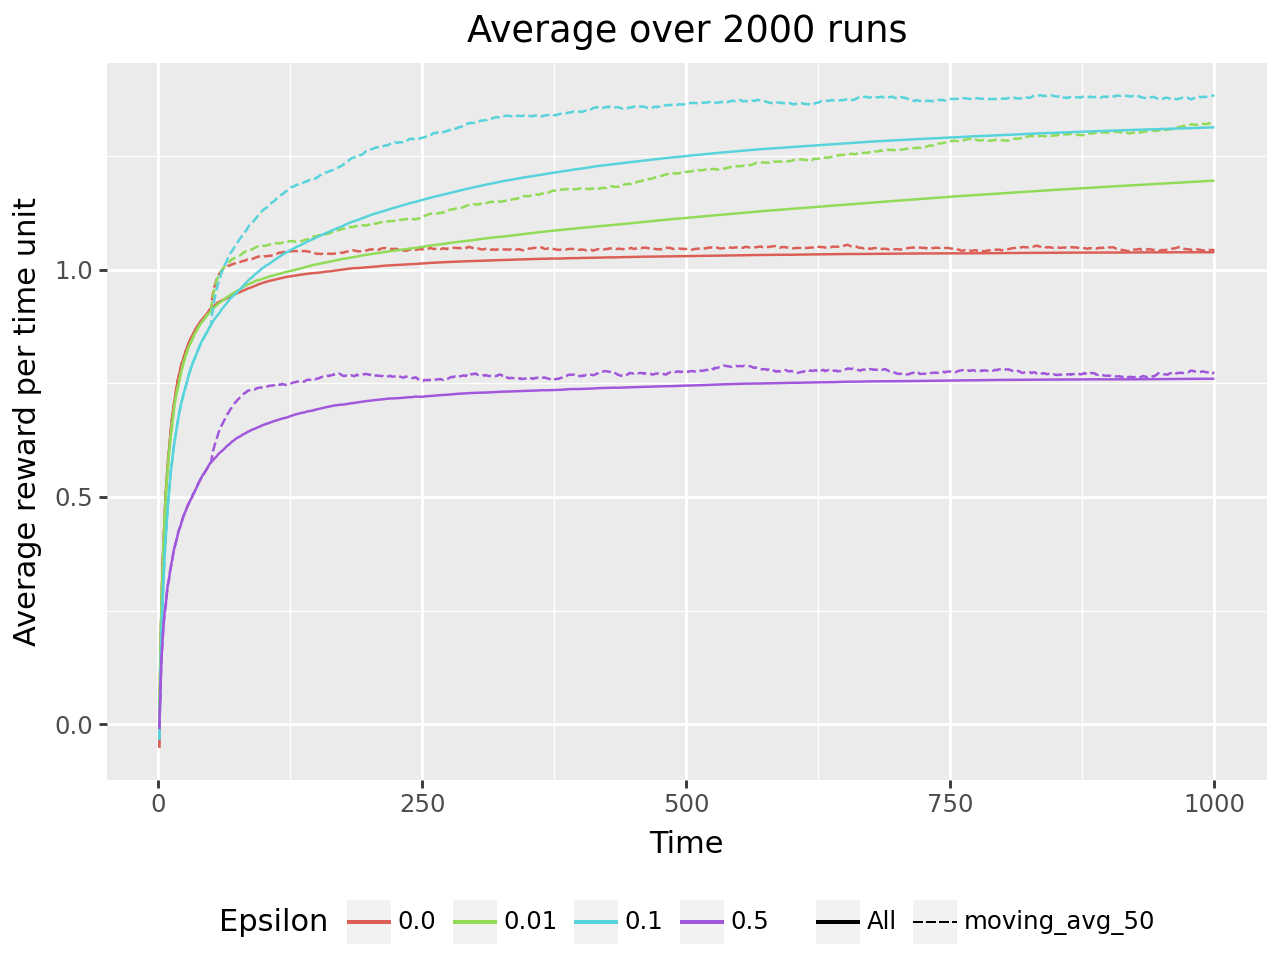

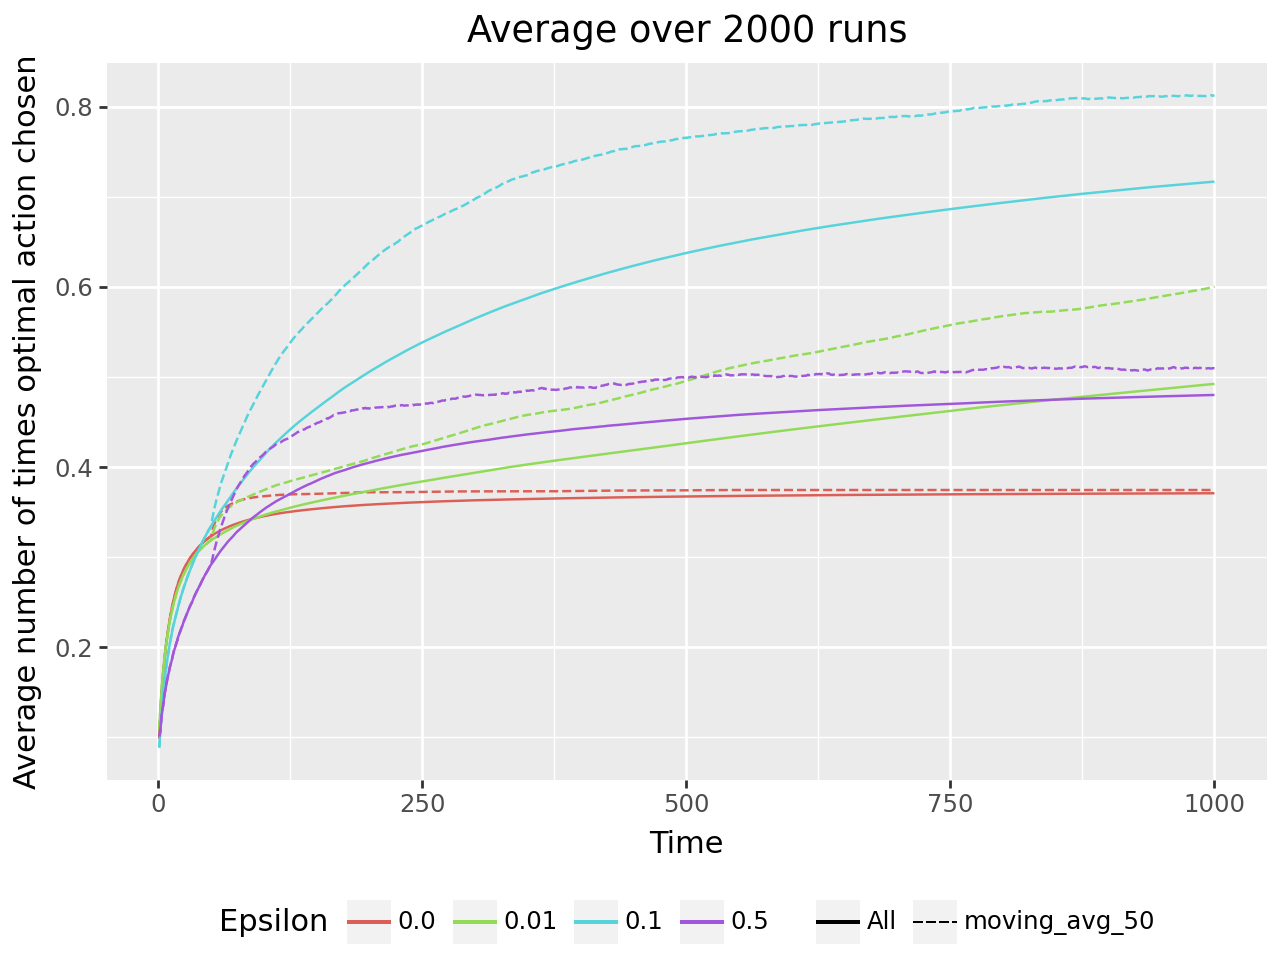

In [ ]:
#@title Measure performance (code)

# Assuming RLAgent and RLEnvironment classes are defined in previous cells as provided in the context

def performance(k=10, time_steps=1000, runs=500, epsilons=[0, 0.01, 0.1, 0.5], ini=0):
    """
    Performance of the bandit algorithm using different epsilons.

    Args:
        k (int): Number of bandits.
        time_steps (int): Time steps used to estimate the expected rewards.
        runs (int): Number of runs with a new environment generated.
        epsilons (list): List of epsilons to be tested.
        ini (float): Initial action-value estimates.

    Returns:
        dict: A dictionary containing two plotnine plots ('ptR' for average reward,
              'ptO' for average number of times optimal action chosen).
    """
    rew = np.zeros((time_steps, len(epsilons)))   # rewards (one col for each eps)
    best = np.zeros((time_steps, len(epsilons)))  # add 1 if find the best action

    for run in range(runs):
        env = RLEnvironment(k)
        oA = env.optimal_action()  # the best action to choose
        for i in range(len(epsilons)):
            agent = RLAgent(k, epsilons[i], ini)
            for t in range(time_steps):
                a = agent.select_action_eg()
                r = env.reward(a)
                agent.update_q(a, r)
                rew[t, i] += r  # sum of rewards generated at t (over all runs)
                best[t, i] += (a == oA) # times find best actions

    # Calculate average rewards and optimal action counts over runs
    # Use pandas DataFrames as the base for dfply operations
    rew_df = pd.DataFrame(rew / runs, columns=epsilons)
    best_df = pd.DataFrame(best / runs, columns=epsilons)

    # Process data for average reward plot using dfply and pandas
    dat1 = (rew_df
            >> gather('epsilon', 'reward', add_id=True) # to long format
            >> rename(t = X._ID)
            >> mutate(t = X.t + 1)
            >> group_by(X.epsilon)
            >> mutate(All=X.reward.cumsum() / X.t,
                      moving_avg_50=X.reward.rolling(window=50, min_periods=1).mean())  # Moving average calculation requires pandas rolling directly
            >> select(~X.reward)
            >> gather('name', 'value', ['All', 'moving_avg_50']) # Use gather from dfply
    )

    # Process data for optimal action plot using dfply and pandas
    dat2 = (best_df
            >> gather('epsilon', 'optimal', add_id=True) # Use gather from dfply
            >> rename(t = X._ID)
            >> mutate(t = X.t + 1)
            >> group_by(X.epsilon)
            >> mutate(All=X.optimal.cumsum() / X.t,
                      moving_avg_50=X.optimal.rolling(window=50, min_periods=1).mean())  # Moving average calculation requires pandas rolling directly
            >> select(~X.optimal)
            >> gather('name', 'value', ['All', 'moving_avg_50']) # Use gather from dfply
    )

    # Create the average reward plot
    pt1 = (
        ggplot(dat1, aes(x='t', y='value', color='epsilon', linetype='name'))
        + geom_line()
        + labs(y='Average reward per time unit', x='Time', title=f'Average over {runs} runs', color='Epsilon', linetype='')
        + theme(legend_position='bottom')
    )
    pt1

    # Create the optimal action plot
    pt2 = (
        ggplot(dat2, aes(x='t', y='value', color='epsilon', linetype='name'))
        + geom_line()
        + labs(y='Average number of times optimal action chosen', x='Time', title=f'Average over {runs} runs', color='Epsilon', linetype='')
        + theme(legend_position='bottom')
    )

    return {'ptR': pt1, 'ptO': pt2}

# Set seed for reproducibility
random.seed(3276)
np.random.seed(3276)

# Run the performance test
plots = performance(runs=2000, time_steps=1000)
# Print the plots
plots['ptR'].show()
plots['ptO'].show()

The solid line shows averages over all the runs from $t=1$ to the considered time-step while the dotted line is a moving average over the last 50 time-steps.


#### Your turn

1. Why is the 50 time-step average higher than the overall average?

 -  We get better over time at estimating, which is why the most recent values should be better.

2. Why is a greedy approach ($\varepsilon = 0$) in general bad?

-  This is because it does not explore, and find the most optimal solution.

3. Why is an $\epsilon$-greedy approach better ($\epsilon = 0.1$)? That is, exploration is beneficial.

-  It explores, and finds the best value.

4. Why is to much exploration not good ($\epsilon = 0.5$)?

-  This is because it explores too much, and does not get the best things. There is a cost of exploring, as it will not give us the optimal reward.

5. What is the effect of reducing the number of time steps on the plots?

In [ ]:
#@title Solutions to questions (code)

# Q2
eps = 0
print(f'\nEpsilon = {eps}')
env = RLEnvironment(k = 5)
print(f'True expected reward values: {env.mean_val}')
agent = RLAgent(k = 5, epsilon = eps)
for t in range(1000):
    a = agent.select_action_eg()
    r = env.reward(a)
    agent.update_q(a, r)
print(f'Estimated expected reward values: {agent.qV}')
print(f'Action counts: {agent.nV}')
print(f'Optimal action: {env.optimal_action()}')

# We might be in a situation where we just stick with the same solution every time.

# Q3
eps = 0.1                               # Set the epislon to 0.1
print(f'\nEpsilon = {eps}')
env = RLEnvironment(k = 5)
print(f'True expected reward values: {env.mean_val}')
agent = RLAgent(k = 5, epsilon = eps)
for t in range(1000):
    a = agent.select_action_eg()
    r = env.reward(a)
    agent.update_q(a, r)
print(f'Estimated expected reward values: {agent.qV}')
print(f'Action counts: {agent.nV}')
print(f'Optimal action: {env.optimal_action()}')


# Q4
eps = 0.5                               # Set the epislon to 0.5
print(f'\nEpsilon = {eps}')
env = RLEnvironment(k = 5)
print(f'True expected reward values: {env.mean_val}')
agent = RLAgent(k = 5, epsilon = eps)
for t in range(1000):
    a = agent.select_action_eg()
    r = env.reward(a)
    agent.update_q(a, r)
print(f'Estimated expected reward values: {agent.qV}')
print(f'Action counts: {agent.nV}')
print(f'Optimal action: {env.optimal_action()}')


Epsilon = 0
True expected reward values: [-0.2987 -1.0946 -0.1982 -0.731   0.1683]
Estimated expected reward values: [-0.863  -1.6435 -0.9683 -0.5461  0.1678]
Action counts: [  2   1   1  54 942]
Optimal action: 4

Epsilon = 0.1
True expected reward values: [-0.3038  1.2896  0.4117  1.0227 -1.2383]
Estimated expected reward values: [-0.3623  1.3417  0.2071  1.0358 -0.8093]
Action counts: [ 16 875  24  67  18]
Optimal action: 1

Epsilon = 0.5
True expected reward values: [0.6672 0.0453 1.375  0.1543 0.3439]
Estimated expected reward values: [0.6506 0.0819 1.3676 0.3065 0.2772]
Action counts: [ 78  97 623 102 100]
Optimal action: 2


## Optimistic initial values

The methods discussed so far are dependent to some extent on the initial action-value estimate i.e. they are biased by their initial estimates. For methods with constant \(\alpha\) this bias is permanent. We may set initial value estimates artificially high to encourage exploration in the short run.




For instance, by setting initial values of $Q$ to 5 rather than 0 we encourage exploration, even in the greedy case. Here the agent will almost always be disappointed with it's samples because they are less than the initial estimate and so will explore elsewhere until the values converge.

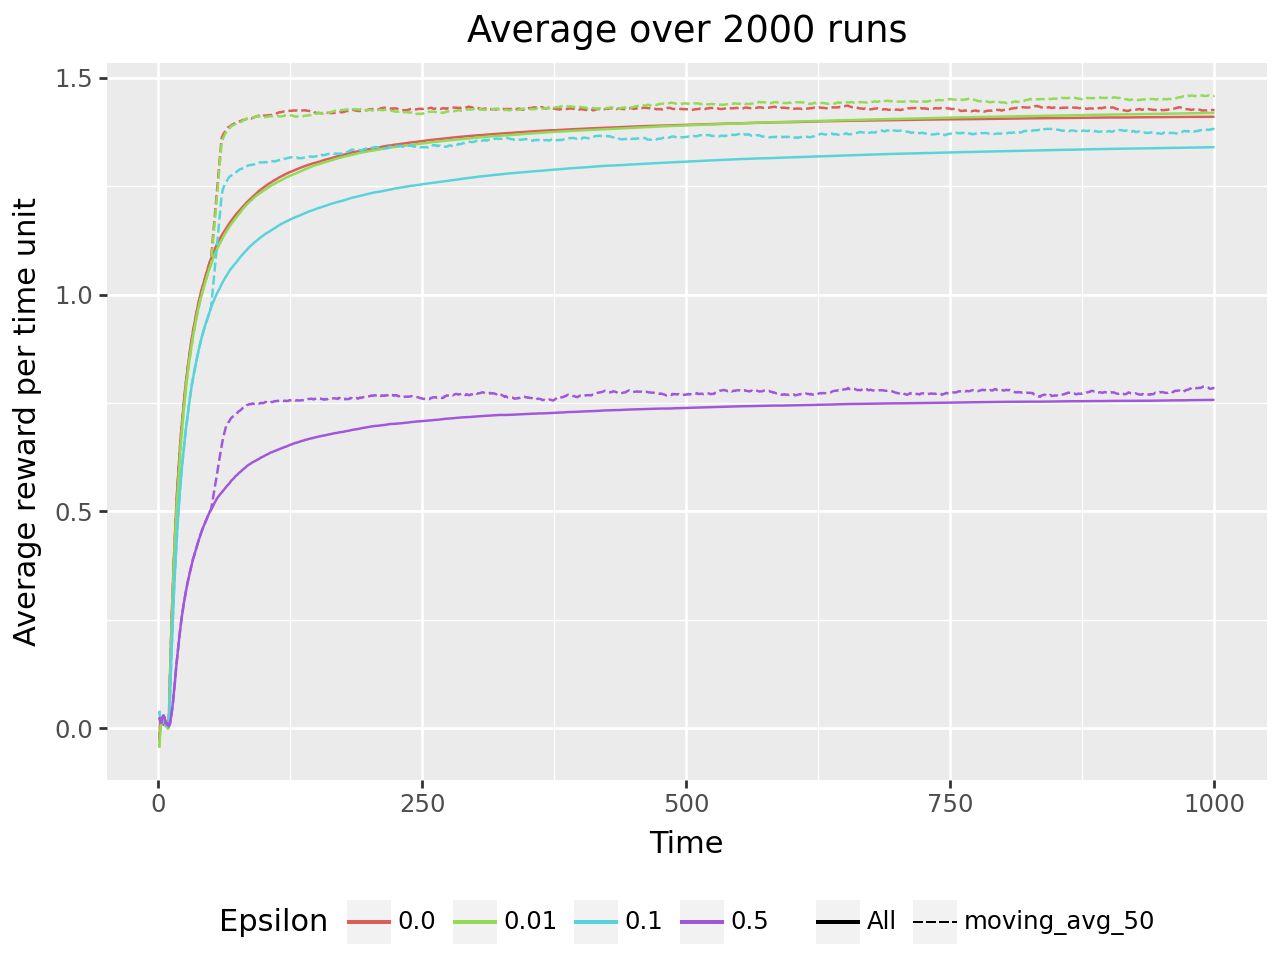

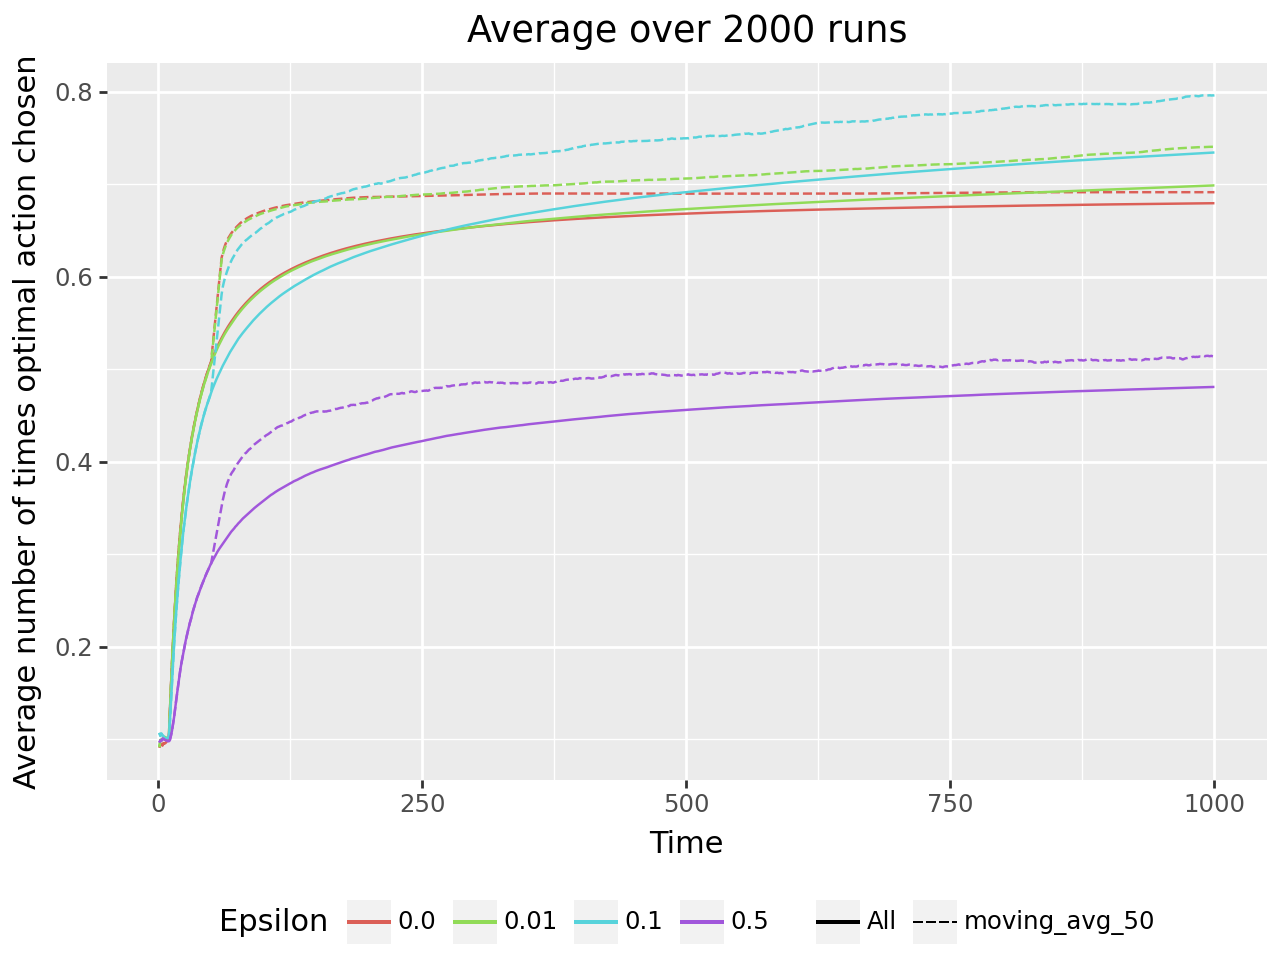

In [ ]:
#@title Your Turn (code)

# Set seed for reproducibility
random.seed(3276)
np.random.seed(3276)

# What will be the effect of setting the initial values to 5 instead of 0?
# Run the performance function and comment on the best exploration rates.
plots = performance(runs=2000, time_steps=1000, ini=5)
plots['ptR'].show()
plots['ptO'].show()




## Upper-Confidence Bound Action Selection

An $\epsilon$-greed algorithm choose the action to explore with equal probability in an exploration step. It would be better to select among non-greedy actions according to their potential for actually being optimal, taking into account both how close their estimates are to being maximal and the uncertainty in those estimates. One way to do this is to select actions using the *upper-confidence bound (UCB)*:
\begin{equation}
	A_t = \arg\max_a \left(Q_t(a) + c\sqrt{\frac{\ln t}{N_t(a)}}\right),
\end{equation}

Note the square root term is a measure of the uncertainty in our estimate (see Figure \@ref(fig:srt)).

* It is proportional to \(t\) i.e. how many time-steps have passed and inversely proportional to \(N_t(a)\) i.e. how many times that action has been visited.
* The more time has passed, and the less we have sampled an action, the higher our upper-confidence-bound.
* As the timesteps increases, the denominator dominates the numerator as the ln term flattens.
* Each time we select an action our uncertainty decreases because $N$ is the denominator of this equation.
* If $N_t(a) = 0$ then we consider $a$ as a maximal action, i.e. we select first among actions with $N_t(a) = 0$.
* The parameter $c>0$ controls the degree of exploration. Higher $c$ results in more weight on the uncertainty.

Since upper-confidence bound action selection select actions according to their potential, it is expected to perform better than $\epsilon$-greedy methods.




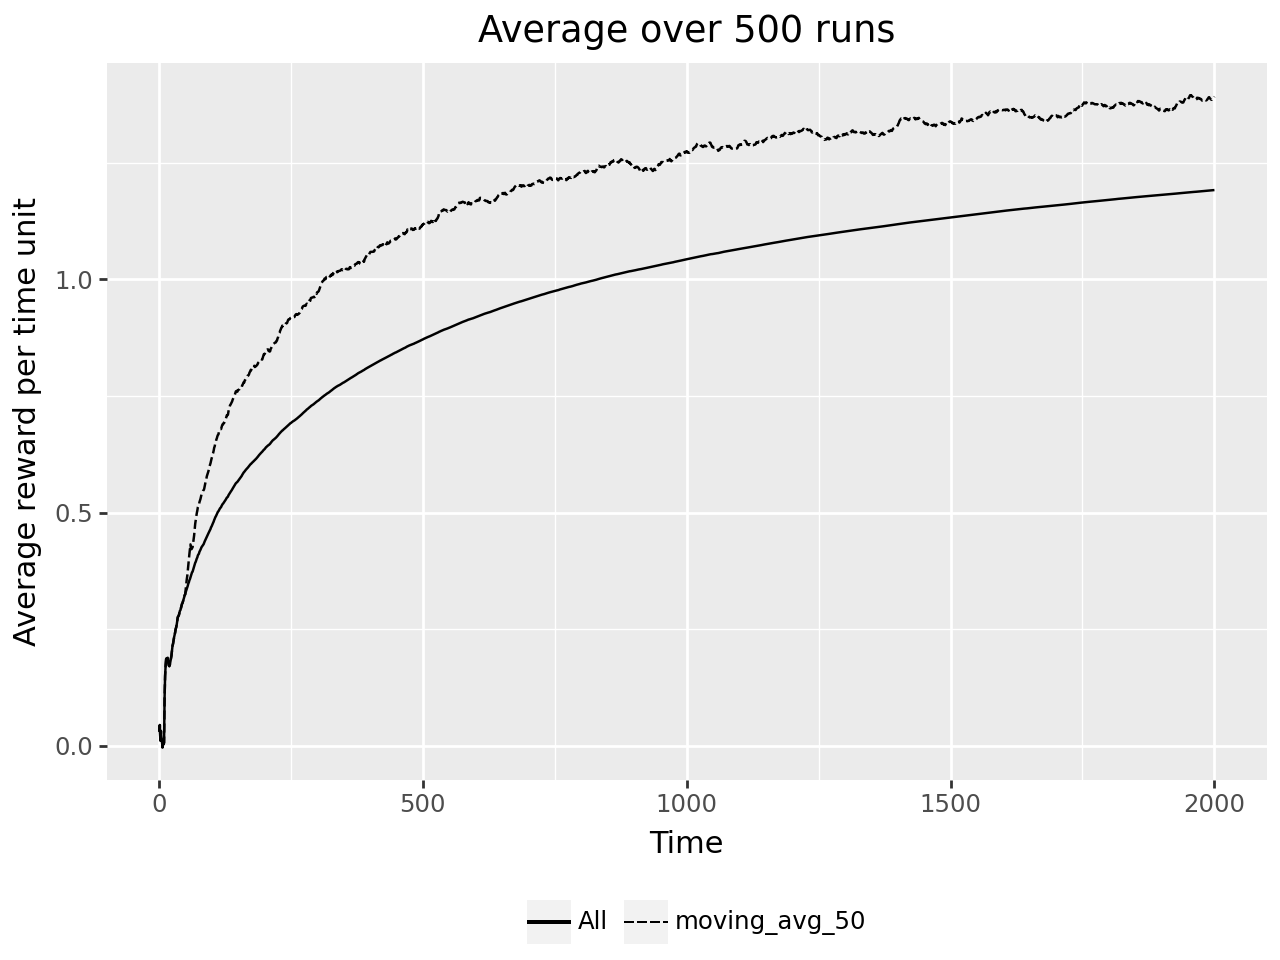

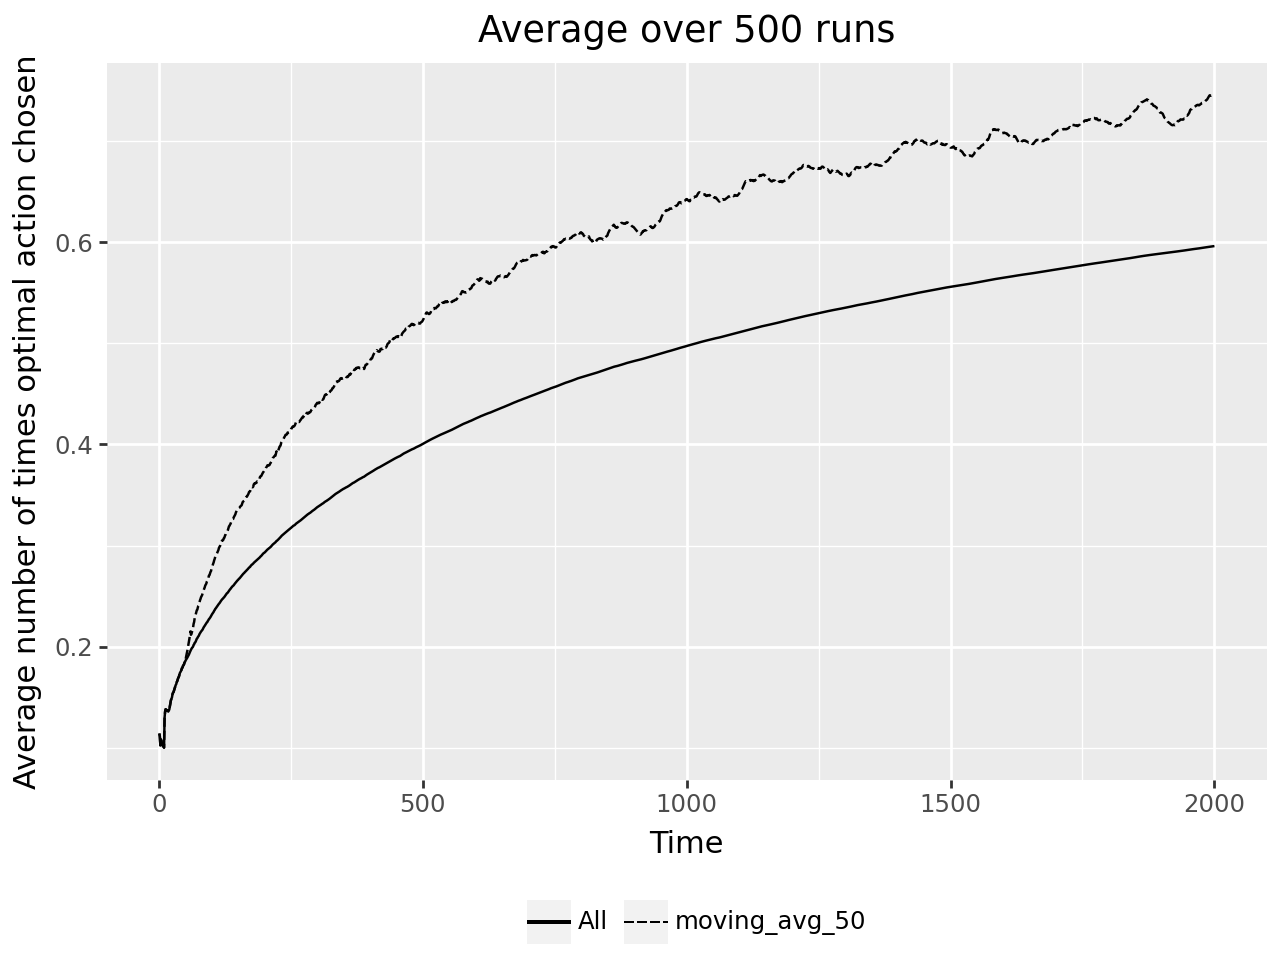

In [ ]:
#@title Your Turn (code)

# Run the algorithm using UCB Action Selection with c = 5, 500 runs, and 2000 timesteps
def performance_ucb(k=10, time_steps=2000, runs=500, ini=0, c = 5):
    """
    Performance of the bandit algorithm using different epsilons (Python version).

    Args:
        k (int): Number of bandits.
        time_steps (int): Time steps.
        runs (int): Number of runs with a new environment generated.
        epsilons (list): List of epsilons to be tested.
        ini (float): Initial value estimates.

    Returns:
        dict: A dictionary containing two plotnine plots ('ptR' for average reward,
              'ptO' for average number of times optimal action chosen).
    """
    rew = np.zeros((time_steps, 1))   # rewards (one col for each eps)
    best = np.zeros((time_steps, 1))  # add 1 if find the best action

    for run in range(runs):
        env = RLEnvironment(k)
        oA = env.optimal_action()  # the best action to choose
        for i in range(1):
            agent = RLAgent(k, 0.1, ini)
            for t in range(time_steps):
                a = agent.select_action_ucb(c, t)
                r = env.reward(a)
                agent.update_q(a, r)
                rew[t, i] += r  # sum of rewards generated at t (over all runs)
                best[t, i] += (a == oA) # times find best actions


    # Calculate average rewards and optimal action counts over runs
    # Use pandas DataFrames as the base for dfply operations
    rew_df = pd.DataFrame(rew / runs)
    best_df = pd.DataFrame(best / runs)

    # Process data for average reward plot using dfply and pandas
    dat1 = (rew_df
            >> gather('epsilon', 'reward', add_id=True) # Use gather from dfply
            >> rename(t = X._ID)
            >> mutate(t = X.t + 1)
            >> group_by(X.epsilon)
            >> mutate(All=X.reward.cumsum() / X.t,
                      moving_avg_50=X.reward.rolling(window=50, min_periods=1).mean())  # Moving average calculation requires pandas rolling directly
            >> select(~X.reward)
            >> gather('name', 'value', ['All', 'moving_avg_50']) # Use gather from dfply

    )

    # Process data for optimal action plot using dfply and pandas
    dat2 = (best_df
            >> gather('epsilon', 'optimal', add_id=True) # Use gather from dfply
            >> rename(t = X._ID)
            >> mutate(t = X.t + 1)
            >> group_by(X.epsilon)
            >> mutate(All=X.optimal.cumsum() / X.t,
                      moving_avg_50=X.optimal.rolling(window=50, min_periods=1).mean())  # Moving average calculation requires pandas rolling directly
            >> select(~X.optimal)
            >> gather('name', 'value', ['All', 'moving_avg_50']) # Use gather from dfply
    )

    # Create the average reward plot
    pt1 = (
        ggplot(dat1, aes(x='t', y='value', linetype='name'))
        + geom_line()
        + labs(y='Average reward per time unit', x='Time', title=f'Average over {runs} runs', color='', linetype='')
        + theme(legend_position='bottom')
    )

    # Create the optimal action plot
    pt2 = (
        ggplot(dat2, aes(x='t', y='value', linetype='name'))
        + geom_line()
        + labs(y='Average number of times optimal action chosen', x='Time', title=f'Average over {runs} runs', color='', linetype='')
        + theme(legend_position='bottom')
    )

    return {'ptR': pt1, 'ptO': pt2}

# Set seed for reproducibility
random.seed(3276)
np.random.seed(3276)

# Run the performance test
plots = performance_ucb()
# Print the plots
plots['ptR'].show()
plots['ptO'].show()

## Exercises

### Exercise - Advertising

Suppose you are an advertiser seeking to optimize which ads to show visitors on a particular website. For each visitor, you can choose one out of a collection of ads, and your goal is to maximize the number of clicks over time. Assume that:

* You have $k=5$ adds to choose among.
* If add $A$ is chosen then the user clicks the add with probability $p_A$ which can be seen as the unknown click trough rate CTR (or an average reward).
* The CTRs are unknown and samples can be picked using the `RLAdEnv` class and the reward function which returns 1 if click on ad and 0 otherwise.

In the class the true CTRs can be observed but in practice this is hidden from the agent (you).



In [75]:
import random
import numpy as np

class RLAdEnv:
    """
    RLAdEnv class representing the RL advertising environment.

    Attributes:
        pr_succes (list): Click-through rates (unknown to the agent).
        k (int): Number of ads.
    """
    def __init__(self, rewards=(1,1,1,1,1)):
        """
        Create an RLAdEnv object.
        Initializes the click-through rates and the number of ads.
        """
        self.pr_succes = [0.1, 0.83, 0.85, 0.5, 0.7] # True click through rates (unknown to the agent)
        self.k = len(self.pr_succes) # Number of ads.
        self.rewards = rewards # rewards given if click

    def reward(self, a):
        """
        Sample reward for a given ad.

        Args:
            a (int): Ad index (0-based).

        Returns:
            int: 1 if click on ad, 0 otherwise.
        """
        # Sample from a binomial distribution with n=1 (single trial)
        # and probability of success equal to the CTR of the selected ad.
        # np.random.binomial(n, p, size)
        return np.random.binomial(1, self.pr_succes[a]) * self.rewards[a]

    def optimal_action(self):
        """
        Returns the index of the ad with the best mean (highest CTR).

        Returns:
            int: Index of the optimal action (0-based).
        """
        # np.argmax returns the index of the maximum value in an array/list.
        return np.argmax(np.array(self.pr_succes) * np.array(self.rewards))

# Example usage:
# Create an instance of the advertising environment
env = RLAdEnv()

# Get a sample reward for choosing ad at index 1 (the second ad)
# This will return 0 or 1 based on the ad's CTR
reward_for_ad_1 = env.reward(1)
print(f"Reward for choosing ad at index 1: {reward_for_ad_1}")

# Find the index of the optimal ad
best_ad_index = env.optimal_action()
print(f"Index of the optimal ad: {best_ad_index}")

# Display the true click-through rates (these are usually unknown to the agent)
true_ctrs = env.pr_succes
print(f"True CTRs of the ads: {true_ctrs}")

Reward for choosing ad at index 1: 0
Index of the optimal ad: 2
True CTRs of the ads: [0.1, 0.83, 0.85, 0.5, 0.7]


#### Q1

Consider an $\epsilon$-greedy algorithm to find the best ad. Assume the webpage is visited by 10000 users per day.

Run the $\epsilon$-greedy algorithm with $\epsilon = 0.01, 0.1, 0.5$ over the 10000 steps. What are the estimated CTRs for each action ($Q_t(a)$)? What is the average number of clicks per user (average total reward)? Hints: You may use the RL agent defined and do a `for` loop that find the action, reward and the total reward so far. Next, you just have to calculate averages and return the correct values.

In [76]:
# Add your solution here

def test_eg(env, epsilon, steps=10000):
    """
    Tests the performance of the epsilon-greedy bandit algorithm in the advertising environment.

    Args:
        epsilon (float): The probability of selecting a random action (exploration).
        steps (int): The total number of time steps (users) for the simulation. Defaults to 10000.

    Returns:
        dict: A dictionary containing:
              - 'qV': The final estimated Q-values (CTRs) for each ad.
              - 'avg_reward': The average reward (clicks) per user over the simulation.
    """
    # Create a new RLAgent instance for the simulation.
    # The agent is initialized with 5 actions (ads) and the specified epsilon.
    agent = RLAgent(k=5, epsilon=epsilon)

    # Initialize the total reward accumulated over the simulation.
    total_reward = 0

    # Loop through each time step, simulating a new user.
    for t in range(steps):
        # The agent selects an action (ad) using the epsilon-greedy strategy.
        action = agent.select_action_eg()

        # The environment provides a reward (click or no click) for the chosen ad.
        reward = env.reward(action)

        # Add the received reward to the total reward.
        total_reward += reward

        # The agent updates its internal estimates (Q-values and action counts)
        # based on the action taken and the reward received.
        agent.update_q(action, reward)

    # Calculate the average reward per step (user).
    average_reward = total_reward / steps

    # Return the final estimated Q-values and the average reward.
    return {'q': agent.qV, 'avg_reward': average_reward}


# Set seeds for reproducibility of results
random.seed(327)
np.random.seed(327)

## Run the test_eg function with different epsilon values to compare their performance.
# The results for each epsilon value (estimated CTRs and average clicks) will be printed.
env = RLAdEnv()
results_001 = test_eg(env, epsilon=0.01, steps=10000)
print(f"Results for epsilon=0.01: qV = {results_001['q']}, Average Reward (clicks) = {results_001['avg_reward']:.4f}")
env = RLAdEnv()
results_01 = test_eg(env, epsilon=0.1, steps=10000)
print(f"Results for epsilon=0.1: qV = {results_01['q']}, Average Reward (clicks) = {results_01['avg_reward']:.4f}")
env = RLAdEnv()
results_05 = test_eg(env, epsilon=0.5, steps=10000)
print(f"Results for epsilon=0.5: qV = {results_05['q']}, Average Reward (clicks) = {results_05['avg_reward']:.4f}")




## Access and print the true optimal action and the true click-through rates.
# This is for comparison with the agent's estimates.
# Note: In a real-world scenario, the agent would not have access to these true values.
print("\n--- True Values (unknown to the agent during learning) ---")
print(f"True optimal action index: {env.optimal_action()}")
print(f"True CTRs of the ads: {env.pr_succes}")

Results for epsilon=0.01: qV = [0.1333 0.8421 0.8537 0.5455 0.7288], Average Reward (clicks) = 0.8474
Results for epsilon=0.1: qV = [0.1143 0.8233 0.8523 0.5327 0.6591], Average Reward (clicks) = 0.8251
Results for epsilon=0.5: qV = [0.0947 0.8438 0.8503 0.5089 0.6908], Average Reward (clicks) = 0.7255

--- True Values (unknown to the agent during learning) ---
True optimal action index: 2
True CTRs of the ads: [0.1, 0.83, 0.85, 0.5, 0.7]


In [ ]:
#@title Solution (do not look too early)

# This cell demonstrates the application of the epsilon-greedy multi-armed bandit algorithm
# to an advertising scenario. It simulates an agent choosing between 5 ads over 10000
# time steps (representing users) and evaluates the performance based on estimated
# click-through rates (CTRs) and average reward (clicks).

def test_eg(env, epsilon, steps=10000):
    """
    Tests the performance of the epsilon-greedy bandit algorithm in the advertising environment.

    Args:
        epsilon (float): The probability of selecting a random action (exploration).
        steps (int): The total number of time steps (users) for the simulation. Defaults to 10000.

    Returns:
        dict: A dictionary containing:
              - 'qV': The final estimated Q-values (CTRs) for each ad.
              - 'avg_reward': The average reward (clicks) per user over the simulation.
    """
    # Create a new RLAgent instance for the simulation.
    # The agent is initialized with 5 actions (ads) and the specified epsilon.
    agent = RLAgent(k=5, epsilon=epsilon)

    # Initialize the total reward accumulated over the simulation.
    total_reward = 0

    # Loop through each time step, simulating a new user.
    for t in range(steps):
        # The agent selects an action (ad) using the epsilon-greedy strategy.
        action = agent.select_action_eg()

        # The environment provides a reward (click or no click) for the chosen ad.
        reward = env.reward(action)

        # Add the received reward to the total reward.
        total_reward += reward

        # The agent updates its internal estimates (Q-values and action counts)
        # based on the action taken and the reward received.
        agent.update_q(action, reward)

    # Calculate the average reward per step (user).
    average_reward = total_reward / steps

    # Return the final estimated Q-values and the average reward.
    return {'q': agent.qV, 'avg_reward': average_reward}


# Set seeds for reproducibility of results
random.seed(327)
np.random.seed(327)

## Run the test_eg function with different epsilon values to compare their performance.
# The results for each epsilon value (estimated CTRs and average clicks) will be printed.
env = RLAdEnv()
results_001 = test_eg(env, 0.01)
print(f"Results for epsilon=0.01: qV = {results_001['q']}, Average Reward (clicks) = {results_001['avg_reward']:.4f}")
results_01 = test_eg(env, 0.1)
print(f"Results for epsilon=0.1: qV = {results_01['q']}, Average Reward (clicks) = {results_01['avg_reward']:.4f}")
results_05 = test_eg(env, 0.5)
print(f"Results for epsilon=0.5: qV = {results_05['q']}, Average Reward (clicks) = {results_05['avg_reward']:.4f}")

## Access and print the true optimal action and the true click-through rates.
# This is for comparison with the agent's estimates.
# Note: In a real-world scenario, the agent would not have access to these true values.
print("\n--- True Values (unknown to the agent during learning) ---")
print(f"True optimal action index: {env.optimal_action()}")
print(f"True CTRs of the ads: {env.pr_succes}")

Results for epsilon=0.01: qV = [0.1333 0.8421 0.8537 0.5455 0.7288], Average Reward (clicks) = 0.8474
Results for epsilon=0.1: qV = [0.1143 0.8233 0.8523 0.5327 0.6591], Average Reward (clicks) = 0.8251
Results for epsilon=0.5: qV = [0.0947 0.8438 0.8503 0.5089 0.6908], Average Reward (clicks) = 0.7255

--- True Values (unknown to the agent during learning) ---
True optimal action index: 2
True CTRs of the ads: [0.1, 0.83, 0.85, 0.5, 0.7]


#### Q2

Make a plot of the empirical CTRs for $\epsilon = 0.01$ and $0.5$ over 10000 time-steps, i.e. plot $Q_t(a)$ over time. Is it best to have a high or a small exploration rate?

[0.1333 0.8421 0.8537 0.5455 0.7288]
Average reward 0.8474


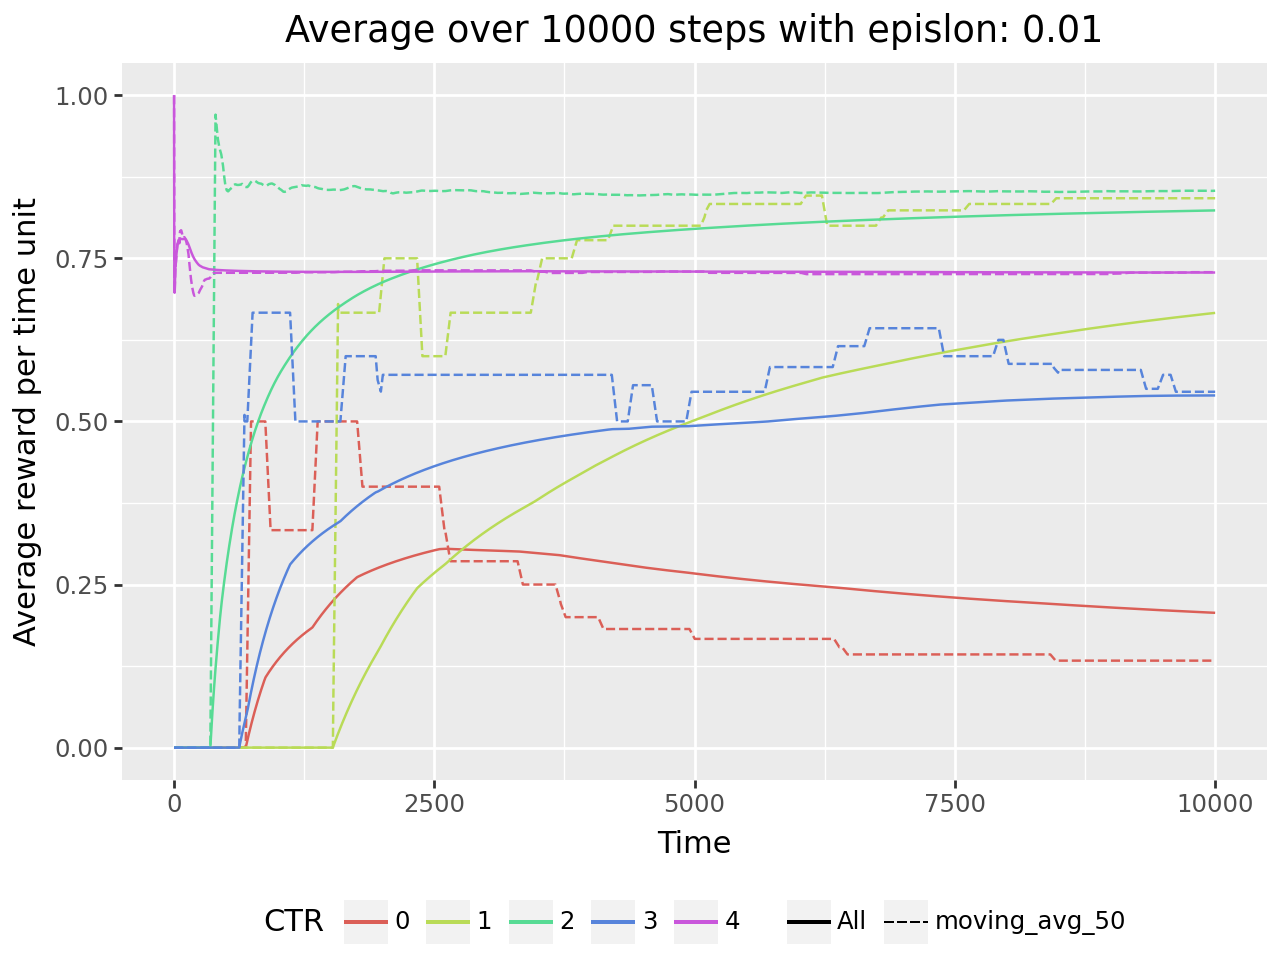

[0.0872 0.8328 0.8489 0.5176 0.7041]
Average reward 0.7188


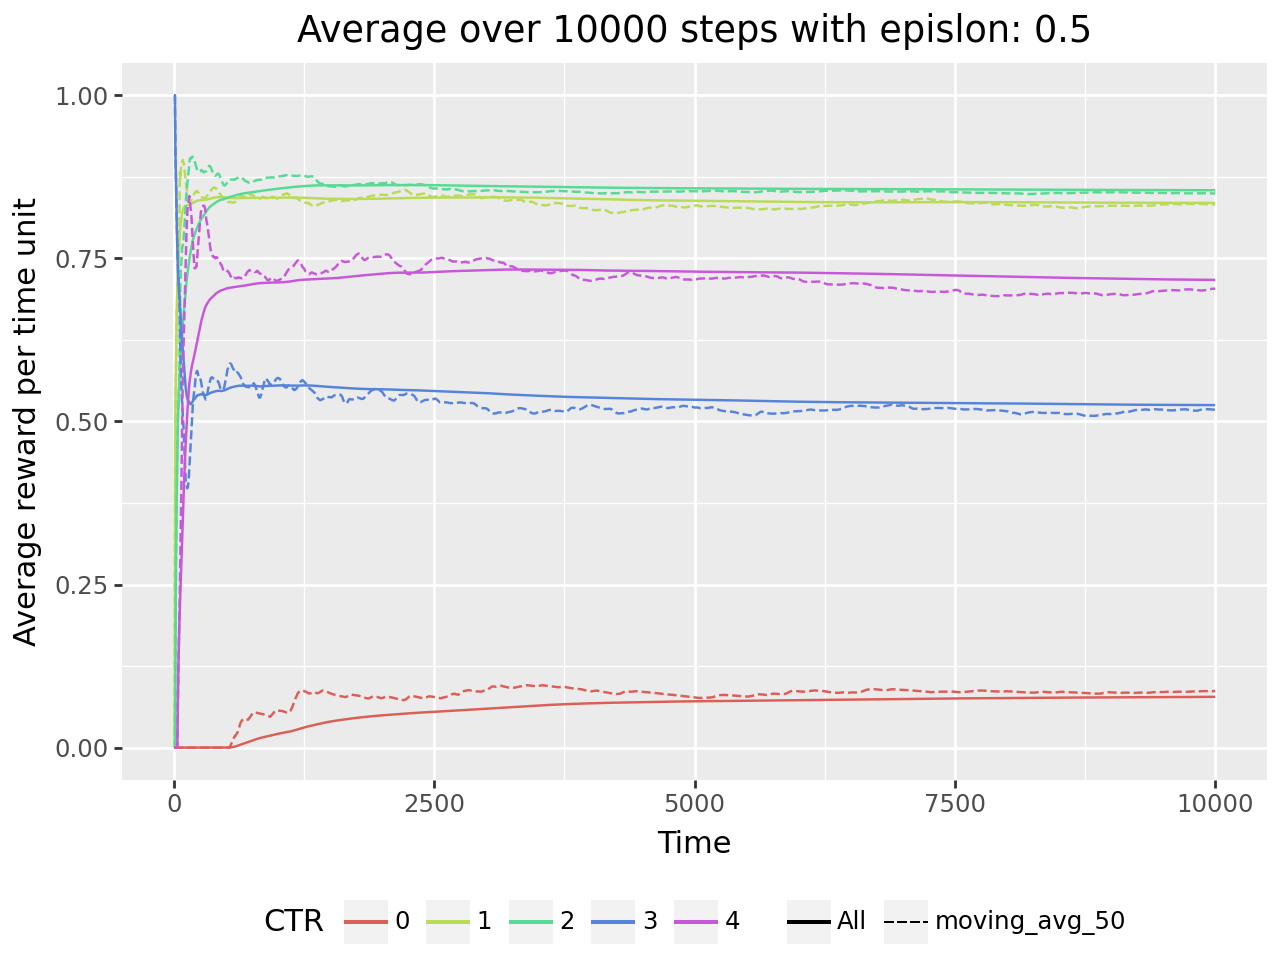

In [77]:
## Your solution here

# Basically we modify the previous test function a bit
def test_eg_with_plot(env, epsilon, steps=10000):
    """
    Tests the performance of the epsilon-greedy bandit algorithm and plots estimated CTRs.

    Args:
        epsilon (float): The probability of selecting a random action (exploration).
        steps (int): The total number of time steps (users) for the simulation.

    Returns:
        dict: A dictionary containing:
              - 'qV': The final estimated Q-values (CTRs) for each ad.
              - 'avg_reward': The average reward (clicks) per user over the simulation.
              - 'plt': The plotnine plot of estimated CTRs over time.
    """
    # Create a new RLAgent instance for the simulation.
    # The agent is initialized with 5 actions (ads) and the specified epsilon.
    agent = RLAgent(k=5, epsilon=epsilon)
    rew = np.zeros((steps, env.k))

    # Initialize the total reward accumulated over the simulation.
    total_reward = 0

    # Loop through each time step, simulating a new user.
    for t in range(steps):
        # The agent selects an action (ad) using the epsilon-greedy strategy.
        action = agent.select_action_eg()

        # The environment provides a reward (click or no click) for the chosen ad.
        reward = env.reward(action)

        # Add the received reward to the total reward.
        total_reward += reward

        # The agent updates its internal estimates (Q-values and action counts)
        # based on the action taken and the reward received.
        agent.update_q(action, reward)
        rew[t, ] += agent.qV

    # Calculate the average reward per step (user).
    average_reward = total_reward / steps
    rew_df = pd.DataFrame(rew / 1, columns=[0, 1, 2, 3, 4])

    dat1 = (rew_df
            >> gather('CTR', 'reward', add_id=True) # to long format
            >> rename(t = X._ID)
            >> mutate(t = X.t + 1)
            >> group_by(X.CTR)
            >> mutate(All=X.reward.cumsum() / X.t,
                      moving_avg_50=X.reward.rolling(window=50, min_periods=1).mean())  # Moving average calculation requires pandas rolling directly
            >> select(~X.reward)
            >> gather('name', 'value', ['All', 'moving_avg_50']) # Use gather from dfply
    )
    pt1 = (
        ggplot(dat1, aes(x='t', y='value', color='CTR', linetype='name'))
        + geom_line()
        + labs(y='Average reward per time unit', x='Time', title=f'Average over {steps} steps with epislon: {epsilon}', color='CTR', linetype='')
        + theme(legend_position='bottom')
    )

    # Return the final estimated Q-values and the average reward.
    return {'q': agent.qV, 'avg_reward': average_reward, 'plt': pt1}


# Set random seed
random.seed(327)
np.random.seed(327)

# Make environment and do the experiment
env = RLAdEnv()
results = test_eg_with_plot(env, 0.01)
print(results['q'])
print(f'Average reward {results['avg_reward']}')
results['plt'].show()

env = RLAdEnv()
results = test_eg_with_plot(env, 0.5)
print(results['q'])
print(f'Average reward {results['avg_reward']}')
results['plt'].show()


In [ ]:
#@title Solution (don't look too early)

# Basically we modify the previous test function a bit
def test_eg_with_plot(env, epsilon, steps=10000):
    """
    Tests the performance of the epsilon-greedy bandit algorithm and plots estimated CTRs.

    Args:
        epsilon (float): The probability of selecting a random action (exploration).
        steps (int): The total number of time steps (users) for the simulation.

    Returns:
        dict: A dictionary containing:
              - 'qV': The final estimated Q-values (CTRs) for each ad.
              - 'avg_reward': The average reward (clicks) per user over the simulation.
              - 'plt': The plotnine plot of estimated CTRs over time.
    """
    agent = RLAgent(k=env.k, epsilon=epsilon)  # Use env.k for the number of ads

    total_reward = 0
    # Initialize a list to store Q-values at each time step
    q_values_history = []

    for t in range(steps):
        action = agent.select_action_eg()
        reward = env.reward(action)
        total_reward += reward
        agent.update_q(action, reward)
        # Store a copy of the current Q-values
        q_values_history.append(agent.qV.copy())

    average_reward = total_reward / steps

    # Convert the history of Q-values to a pandas DataFrame for plotting
    q_values_df = pd.DataFrame(q_values_history, columns=[f'A{i}' for i in range(env.k)])
    q_values_df['t'] = range(1, steps + 1)

    # Melt the DataFrame to long format for plotting
    dat = q_values_df.melt(id_vars='t', var_name='action', value_name='ctr')

    # Create the plot using plotnine
    pt = (
        ggplot(dat, aes(x='t', y='ctr', color='action'))
        + geom_line()
        + labs(y='Empirical CTRs', x='Time', title=f'CTRs eps = {epsilon} avg = {average_reward}', color='Action')
        + theme(legend_position='bottom')
    )

    return {'q': agent.qV, 'avg_reward': average_reward, 'plt': pt}

# Test different epsilon values and showing the plots:
env = RLAdEnv()
random.seed(327) # Keep the same seed as the R code for reproducibility
np.random.seed(327)

results_001_plot = test_eg_with_plot(env, 0.01)
results_001_plot['plt'].show()

results_05_plot = test_eg_with_plot(env, 0.5)
results_05_plot['plt'].show()

#### Q3

Assume that the rewards of ad clicks is equal to (10, 8, 5, 15, 2). Modify the algorithm so you look at rewards instead of CTRs. What is the best action to choose? Hint: Have a look at the rewards argument when you define the `RLAgent`class.

[1.3333 7.1111 4.3212 7.55   1.4575]
Average reward 7.22


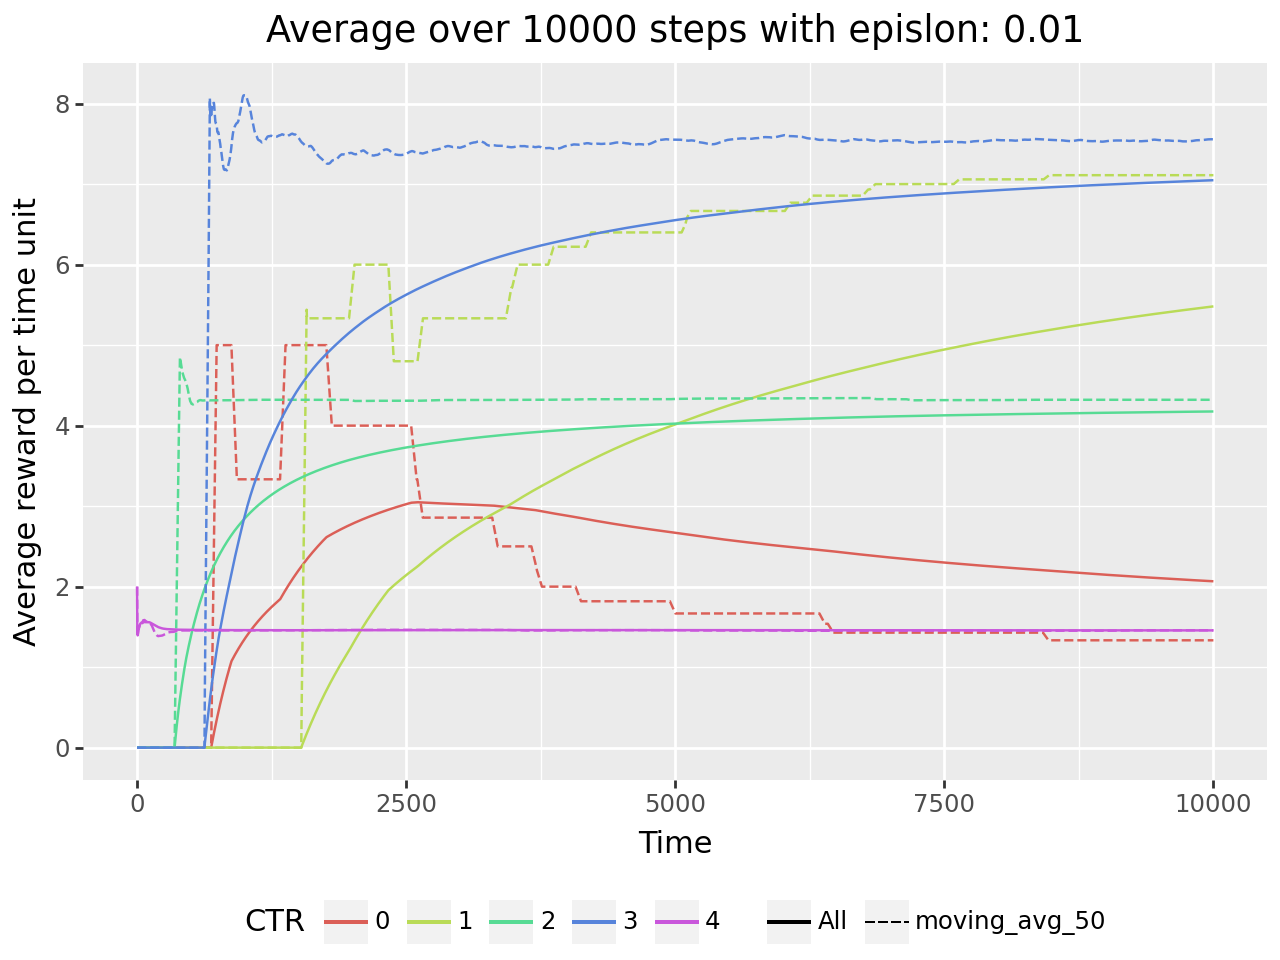

[1.1429 6.5641 4.2526 7.5318 1.3084]
Average reward 7.182


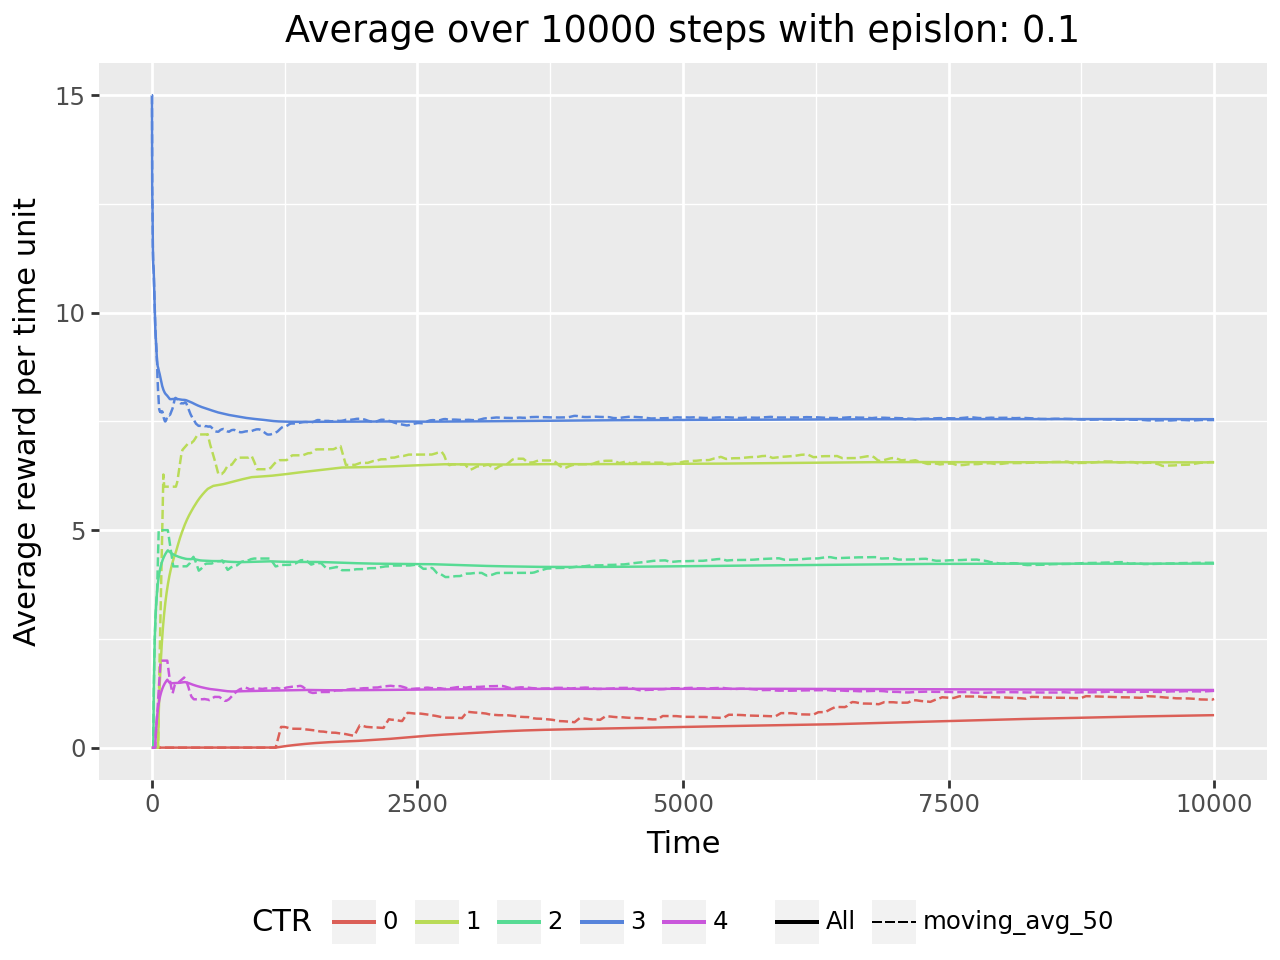

[0.947  6.7797 4.2315 7.5855 1.383 ]
Average reward 5.9041


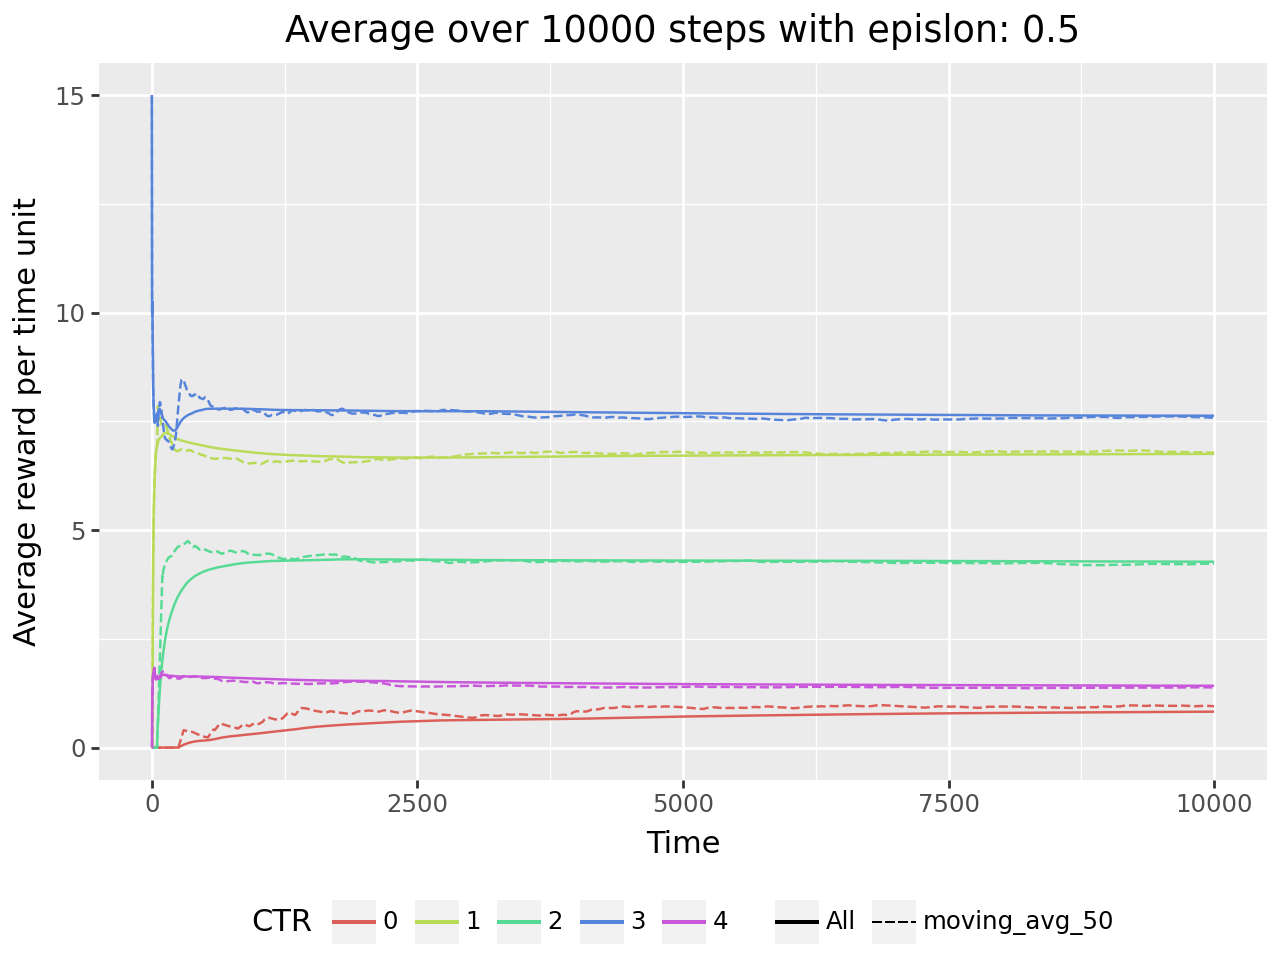

In [78]:
## Your solution here

random.seed(327)
np.random.seed(327)

env = RLAdEnv(rewards=[10, 8, 5, 15, 2])
results = test_eg_with_plot(env, 0.01)
print(results['q'])
print(f'Average reward {results['avg_reward']}')
results['plt'].show()

env = RLAdEnv(rewards=[10, 8, 5, 15, 2])
results = test_eg_with_plot(env, 0.1)
print(results['q'])
print(f'Average reward {results['avg_reward']}')
results['plt'].show()



env = RLAdEnv(rewards=[10, 8, 5, 15, 2])
results = test_eg_with_plot(env, 0.5)
print(results['q'])
print(f'Average reward {results['avg_reward']}')
results['plt'].show()

In [ ]:
#@title Solution (don't look too early)

# Example usage with different epsilon values and showing the plots:
random.seed(3527) # Keep the same seed as the R code for reproducibility
np.random.seed(3527)

# Run the test_eg function with different epsilon values to compare their performance.
# The results for each epsilon value (estimated CTRs and average clicks) will be printed.
env = RLAdEnv(rewards=(10, 8, 5, 15, 2))
results_001_plot = test_eg_with_plot(env, 0.01)
results_001_plot['plt'].show()
print(f"Results for epsilon=0.01: Average Reward = {results_001_plot['avg_reward']:.4f}")

results_01_plot = test_eg_with_plot(env, 0.1)
results_01_plot['plt'].show()
print(f"Results for epsilon=0.1: Average Reward = {results_01_plot['avg_reward']:.4f}")

results_05_plot = test_eg_with_plot(env, 0.5)
results_05_plot['plt'].show()
print(f"Results for epsilon=0.5: Average Reward = {results_05_plot['avg_reward']:.4f}")

#### Q4

We now focus on choosing the action using an upper-confidence bound function. Have a look at the function `select_action_ucb` in the `RLAgent` class.

Test the UCB algorithm for $c$ values $(0.1, 5, 10, 20)$. Which algorithm seems to find the best average reward (use the rewards from Q3)?



In [91]:
## Your solution here

def test_ucb(env, steps=10000, c=2):
    """
    Tests the performance of the UCB bandit algorithm and plots estimated CTRs.

    Args:
        env: RL environment
        steps (int): The total number of time steps (users) for the simulation.
        c (float): The parameter for UCB.

    Returns:
        dict: A dictionary containing:
              - 'q': The final estimated Q-values (CTRs) for each ad.
              - 'visits': The number of times each ad has been visited.
              - 'avg_reward': The average reward (clicks) per user over the simulation.
    """
    # Create a new RLAgent instance for the simulation.
    # The agent is initialized with 5 actions (ads) and the specified epsilon.
    k = 5
    agent = RLAgent(k=k)

    # Initialize the total reward accumulated over the simulation.
    total_reward = 0

    # Loop through each time step, simulating a new user.
    for t in range(steps):
        # The agent selects an action (ad) using the epsilon-greedy strategy.
        action = agent.select_action_ucb(c, t)

        # The environment provides a reward (click or no click) for the chosen ad.
        reward = env.reward(action)

        # Add the received reward to the total reward.
        total_reward += reward

        # The agent updates its internal estimates (Q-values and action counts)
        # based on the action taken and the reward received.
        agent.update_q(action, reward)

    # Calculate the average reward per step (user).
    average_reward = total_reward / steps

    # Return the final estimated Q-values and the average reward.
    return {'q': agent.qV, 'visits': agent.nV, 'avg_reward': average_reward}

# Set seeds for reproducibility of results
# random.seed(327)
# np.random.seed(327)

## Run the test_eg function with different epsilon values to compare their performance.
# The results for each epsilon value (estimated CTRs and average clicks) will be printed.
env = RLAdEnv(rewards=(10, 8, 5, 15, 2))
results_01 = test_ucb(env, c=0.1, steps=10000)
print(f"Results for c=0.1: qV = {results_01['q']}, visits = {results_01['visits']}, Average Reward (clicks) = {results_01['avg_reward']:.4f}")
env = RLAdEnv(rewards=(10, 8, 5, 15, 2))
results_5 = test_ucb(env, c=5, steps=10000)
print(f"Results for c=5: qV = {results_5['q']}, visits = {results_5['visits']}, Average Reward (clicks) = {results_5['avg_reward']:.4f}")
env = RLAdEnv(rewards=(10, 8, 5, 15, 2))
results_10 = test_ucb(env, c=10, steps=10000)
print(f"Results for c=10: qV = {results_10['q']}, visits = {results_10['visits']}, Average Reward (clicks) = {results_10['avg_reward']:.4f}")
env = RLAdEnv(rewards=(10, 8, 5, 15, 2))
results_20 = test_ucb(env, c=20, steps=10000)
print(f"Results for c=20: qV = {results_20['q']}, visits = {results_20['visits']}, Average Reward (clicks) = {results_20['avg_reward']:.4f}")

print("\n--- True Values (unknown to the agent during learning) ---")
print(f"True optimal action index: {env.optimal_action()}")
print(f"True CTRs of the ads: {env.pr_succes}")


Results for c=0.1: qV = [0.     0.     4.2092 0.     0.    ], visits = [   1    1 9996    1    1], Average Reward (clicks) = 4.2075
Results for c=5: qV = [1.4286 6.4762 4.4444 7.4401 1.7143], visits = [   7  189   27 9770    7], Average Reward (clicks) = 7.4056
Results for c=10: qV = [0.9524 6.5372 4.1429 7.4612 0.9524], visits = [  21  618   70 9270   21], Average Reward (clicks) = 7.3535
Results for c=20: qV = [1.3415 6.4537 4.1239 7.428  1.3902], visits = [  82 1371  234 8231   82], Average Reward (clicks) = 7.1177

--- True Values (unknown to the agent during learning) ---
True optimal action index: 3
True CTRs of the ads: [0.1, 0.83, 0.85, 0.5, 0.7]


In [85]:
#@title Solution (don't look too early)

def test_ucb_with_plot(env, steps=10000, c=2):
    """
    Tests the performance of the UCB bandit algorithm and plots estimated CTRs.

    Args:
        env: RL environment
        steps (int): The total number of time steps (users) for the simulation.
        c (float): The parameter for UCB.

    Returns:
        dict: A dictionary containing:
              - 'q': The final estimated Q-values (CTRs) for each ad.
              - 'visits': The number of times each ad has been visited.
              - 'avg_reward': The average reward (clicks) per user over the simulation.
    """
    agent = RLAgent(k=env.k)  # Use env.k for the number of ads

    total_reward = 0
    # Initialize a list to store Q-values at each time step
    q_values_history = []

    for t in range(steps):
        action = agent.select_action_ucb(c, t)
        reward = env.reward(action)
        total_reward += reward
        agent.update_q(action, reward)
        # Store a copy of the current Q-values
        q_values_history.append(agent.qV.copy())

    average_reward = total_reward / steps

    # Convert the history of Q-values to a pandas DataFrame for plotting
    q_values_df = pd.DataFrame(q_values_history, columns=[f'A{i}' for i in range(env.k)])
    q_values_df['t'] = range(1, steps + 1)

    # Melt the DataFrame to long format for plotting
    dat = q_values_df.melt(id_vars='t', var_name='action', value_name='ctr')

    # Create the plot using plotnine
    pt = (
        ggplot(dat, aes(x='t', y='ctr', color='action'))
        + geom_line()
        + labs(y='Empirical reward', x='Time', title=f'Rewards c = {c}', color='Action')
        + theme(legend_position='bottom')
    )

    rew_diff = abs(np.array(env.pr_succes) * np.array(env.rewards) - np.array(agent.qV) )
    return {'q': agent.qV, 'visits': agent.nV, 'avg_reward': average_reward, 'plt': pt}

# Example usage with different epsilon values and showing the plots:
random.seed(3527) # Keep the same seed as the R code for reproducibility
np.random.seed(3527)

# Run the test_eg function with different epsilon values to compare their performance.
# The results for each epsilon value (estimated CTRs and average clicks) will be printed.
env = RLAdEnv(rewards=(10, 8, 5, 15, 2))
print("True expected reward:", np.array(env.pr_succes) * np.array(env.rewards))

c = [0.1,5,10,20]
for c_val in c:
    results = test_ucb_with_plot(env, c=c_val)
    print(f"Results for c = {c_val}: q = {results['q']}, visits = {results['visits']}, Average total reward = {results['avg_reward']:.4f}")


True expected reward: [1.   6.64 4.25 7.5  1.4 ]
Results for c = 0.1: q = [0.     6.6629 4.     0.     2.    ], visits = [   1 9992    5    1    1], Average total reward = 6.6598
Results for c = 5: q = [2.7273 6.6019 3.9474 7.467  1.3333], visits = [  11  412   19 9552    6], Average total reward = 7.4158
Results for c = 10: q = [0.5556 6.7828 4.2949 7.4875 1.2727], visits = [  18  907   78 8975   22], Average total reward = 7.3725
Results for c = 20: q = [1.0667 6.7077 4.0611 7.4113 1.3902], visits = [  75 1919  229 7695   82], Average total reward = 7.1026


#### Q5

Assume that you get insider tips from different people:

1. The best commercial is either action 1 or 3 of commercial 0 to 4.
2. I think the best commercial is 2.
3. Always use commercial 3 and you will have good earnings.

Assume that you only have 50 trials.
Modify your UCB learning algorithm (set $c$ and modify initial $q$ and $n$ values), so learn best.

/tmp/ipython-input-3447368019.py:68: RuntimeWarning: divide by zero encountered in log
/tmp/ipython-input-3447368019.py:68: RuntimeWarning: invalid value encountered in sqrt
/tmp/ipython-input-3447368019.py:68: RuntimeWarning: invalid value encountered in divide
/tmp/ipython-input-3447368019.py:68: RuntimeWarning: divide by zero encountered in divide
/tmp/ipython-input-3447368019.py:68: RuntimeWarning: invalid value encountered in multiply


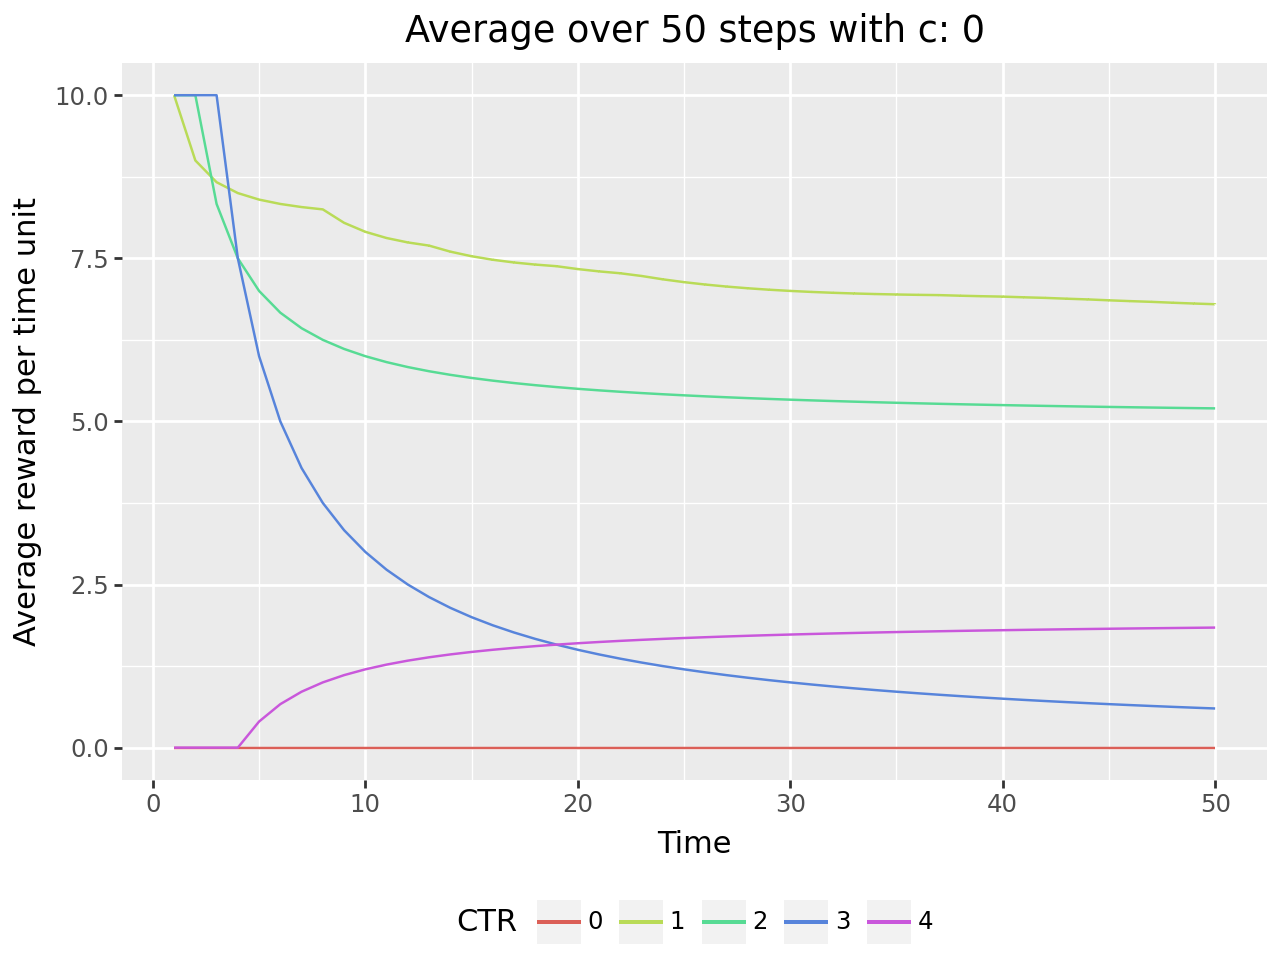

5.9

In [108]:
## Your solution here

def test_ucb_with_plot(env, initial_q, initial_n, steps=50, c=5):
    """
    Tests the performance of the epsilon-greedy bandit algorithm and plots estimated CTRs.

    Args:
        env: RL environment
        initial_q: Initial estimated Q-values (CTRs) for each ad.
        initial_n: Initial number of times each ad has been visited.
        steps (int): The total number of time steps (users) for the simulation.
        c (float): The parameter for UCB.

    Returns:
        dict: A dictionary containing:
              - 'q': The final estimated Q-values (CTRs) for each ad.
              - 'visits': The number of times each ad has been visited.
              - 'avg_reward': The average reward (clicks) per user over the simulation.
              - 'plt': The plotnine plot of estimated CTRs over time.

    """
    # Create a new RLAgent instance for the simulation.
    # The agent is initialized with 5 actions (ads) and the specified epsilon.
    k = 5
    agent = RLAgent(k=k)
    agent.qV = initial_q
    agent.nV = initial_n
    rew = np.zeros((steps, env.k))

    # Initialize the total reward accumulated over the simulation.
    total_reward = 0

    # Loop through each time step, simulating a new user.
    for t in range(steps):
        # The agent selects an action (ad) using the epsilon-greedy strategy.
        action = agent.select_action_ucb(c, t)

        # The environment provides a reward (click or no click) for the chosen ad.
        reward = env.reward(action)

        # Add the received reward to the total reward.
        total_reward += reward

        # The agent updates its internal estimates (Q-values and action counts)
        # based on the action taken and the reward received.
        agent.update_q(action, reward)
        rew[t, ] += agent.qV

    # Calculate the average reward per step (user).
    average_reward = total_reward / steps
    rew_df = pd.DataFrame(rew / 1, columns=[0, 1, 2, 3, 4])

    dat1 = (rew_df
            >> gather('CTR', 'reward', add_id=True) # to long format
            >> rename(t = X._ID)
            >> mutate(t = X.t + 1)
            >> group_by(X.CTR)
            >> mutate(All=X.reward.cumsum() / X.t,
                      moving_avg_50=X.reward.rolling(window=50, min_periods=1).mean())  # Moving average calculation requires pandas rolling directly
            >> select(~X.reward)
            >> gather('name', 'value', ['All', 'moving_avg_50']) # Use gather from dfply
    )
    pt1 = (
        ggplot(dat1, aes(x='t', y='value', color='CTR'))
        + geom_line()
        + labs(y='Average reward per time unit', x='Time', title=f'Average over {steps} steps with c: {c}', color='CTR', linetype='')
        + theme(legend_position='bottom')
    )

    # Return the final estimated Q-values and the average reward.
    return {'q': agent.qV, 'visits': agent.nV, 'avg_reward': average_reward, 'plt': pt1}


env = RLAdEnv(rewards=(10, 8, 5, 15, 2))
# Setting high q for 1, 2, 3
results = test_ucb_with_plot(env,
                             initial_q=[0, 10, 10, 10, 0],
                             initial_n=[0, 0, 0, 0, 0],
                             c=0)
results['plt'].show()
results['avg_reward']

True expected reward: [1.   6.64 4.25 7.5  1.4 ]
Choose a = 0 rew = 0 q = [0.0, 1.0, 1.0, 2.0, 0.0]
Choose a = 4 rew = 2 q = [0.0, 1.0, 1.0, 2.0, 2.0]
Choose a = 4 rew = 2 q = [0.0, 1.0, 1.0, 2.0, 2.0]
Choose a = 4 rew = 2 q = [0.0, 1.0, 1.0, 2.0, 2.0]
Choose a = 0 rew = 0 q = [0.0, 1.0, 1.0, 2.0, 2.0]
Choose a = 4 rew = 0 q = [0.0, 1.0, 1.0, 2.0, 1.5]
Choose a = 4 rew = 2 q = [0.0, 1.0, 1.0, 2.0, 1.6]
Choose a = 0 rew = 0 q = [0.0, 1.0, 1.0, 2.0, 1.6]
Choose a = 4 rew = 2 q = [0.0, 1.0, 1.0, 2.0, 1.6666666666666667]
Choose a = 4 rew = 0 q = [0.0, 1.0, 1.0, 2.0, 1.4285714285714286]
Choose a = 3 rew = 15 q = [0.0, 1.0, 1.0, 3.1818181818181817, 1.4285714285714286]
Choose a = 3 rew = 0 q = [0.0, 1.0, 1.0, 2.9166666666666665, 1.4285714285714286]
Choose a = 3 rew = 0 q = [0.0, 1.0, 1.0, 2.692307692307692, 1.4285714285714286]
Choose a = 3 rew = 0 q = [0.0, 1.0, 1.0, 2.5, 1.4285714285714286]
Choose a = 0 rew = 0 q = [0.0, 1.0, 1.0, 2.5, 1.4285714285714286]
Choose a = 3 rew = 15 q = [0.0, 1.0,

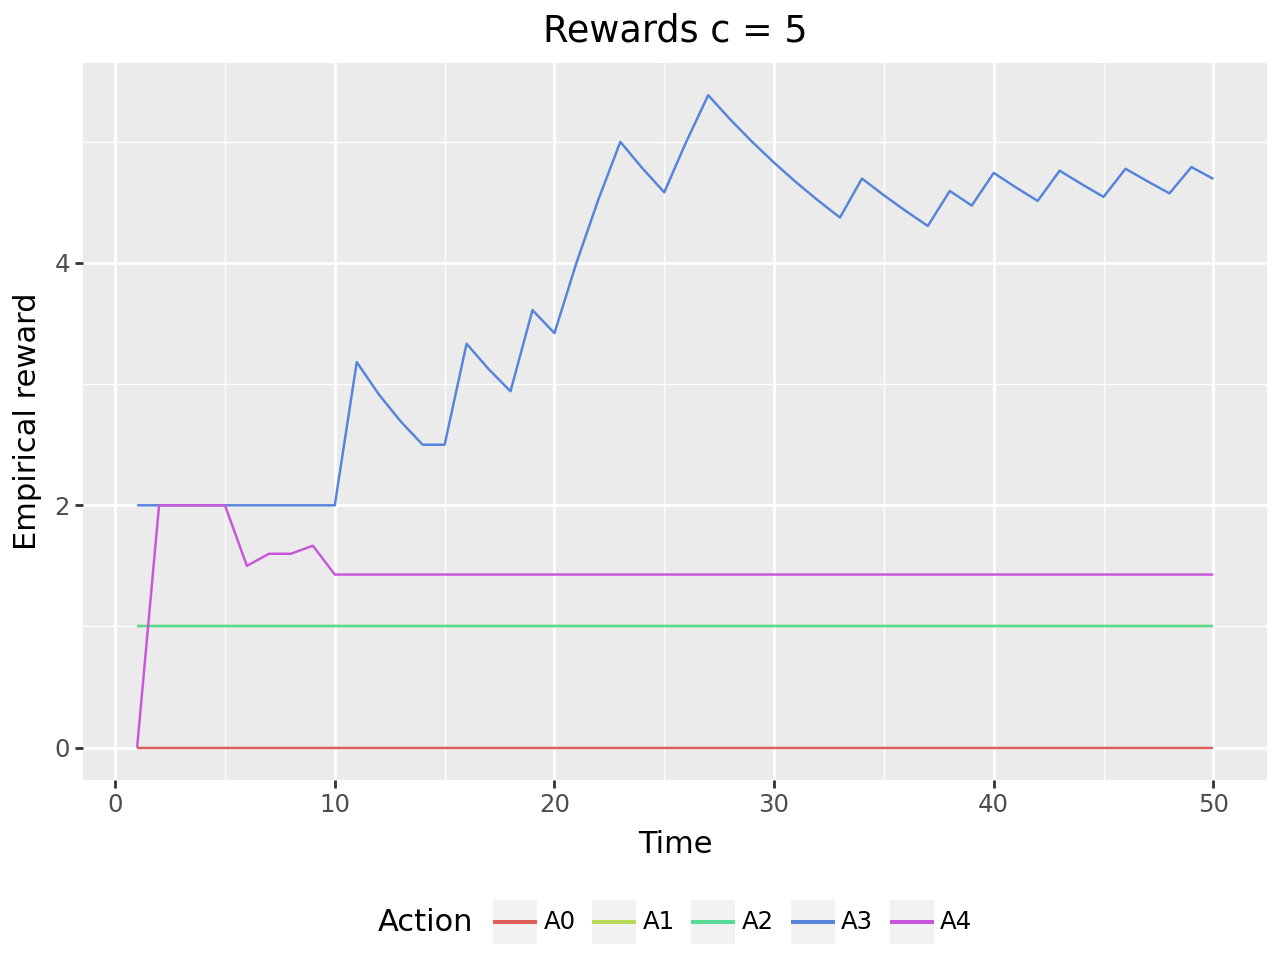

Results for c = 5: q = [0.     1.     1.     4.6939 1.4286], visits = [ 4 10 10 49  7], Average total reward = 4.4000


In [109]:
#@title Solution (don't look too early)

def test_ucb_with_plot(env, initial_q, initial_n, steps=50, c=5):
    """
    Tests the performance of the epsilon-greedy bandit algorithm and plots estimated CTRs.

    Args:
        env: RL environment
        initial_q: Initial estimated Q-values (CTRs) for each ad.
        initial_n: Initial number of times each ad has been visited.
        steps (int): The total number of time steps (users) for the simulation.
        c (float): The parameter for UCB.

    Returns:
        dict: A dictionary containing:
              - 'q': The final estimated Q-values (CTRs) for each ad.
              - 'visits': The number of times each ad has been visited.
              - 'avg_reward': The average reward (clicks) per user over the simulation.
              - 'plt': The plotnine plot of estimated CTRs over time.

    """
    agent = RLAgent(k=env.k)  # Use env.k for the number of ads
    agent.qV = initial_q
    agent.nV = initial_n
    total_reward = 0
    # Initialize a list to store Q-values at each time step
    q_values_history = []

    for t in range(steps):
        action = agent.select_action_ucb(c, t)
        reward = env.reward(action)
        total_reward += reward
        agent.update_q(action, reward)
        print("Choose a =", action, "rew =", reward, "q =", agent.qV.tolist())
        # Store a copy of the current Q-values
        q_values_history.append(agent.qV.copy())

    average_reward = total_reward / steps

    # Convert the history of Q-values to a pandas DataFrame for plotting
    q_values_df = pd.DataFrame(q_values_history, columns=[f'A{i}' for i in range(env.k)])
    q_values_df['t'] = range(1, steps + 1)

    # Melt the DataFrame to long format for plotting
    dat = q_values_df.melt(id_vars='t', var_name='action', value_name='ctr')

    # Create the plot using plotnine
    pt = (
        ggplot(dat, aes(x='t', y='ctr', color='action'))
        + geom_line()
        + labs(y='Empirical reward', x='Time', title=f'Rewards c = {c}', color='Action')
        + theme(legend_position='bottom')
    )

    return {'q': agent.qV, 'visits': agent.nV, 'avg_reward': average_reward, 'plt': pt}

# Example usage with different epsilon values and showing the plots:
random.seed(3527) # Keep the same seed as the R code for reproducibility
np.random.seed(3527)

# Run the test_eg function with different epsilon values to compare their performance.
# The results for each epsilon value (estimated CTRs and average clicks) will be printed.
env = RLAdEnv(rewards= (10, 8, 5, 15, 2))
print("True expected reward:", np.array(env.pr_succes) * np.array(env.rewards))

results = test_ucb_with_plot(env, initial_q = np.array([0, 1.0, 1.0, 2.0, 0]), initial_n = np.array([0, 10, 10, 10, 0]), c = 5)
results['plt'].show()
print(f"Results for c = 5: q = {results['q']}, visits = {results['visits']}, Average total reward = {results['avg_reward']:.4f}")


### Exercise - A coin game

Consider a game where you choose to flip one of two (possibly unfair) coins. You win 1 if your chosen coin shows heads and lose 1 if it shows tails. Answer the following questions (you don't need to code anything).

#### Q1

Model this as a K-armed bandit problem: define the action set.

<details>
<summary>Solution (don't look too early)</summary>
This is a 2-bandit problem with actions of choosing coin 1 or 2.
</details>

Action set:
* A1: Flip coin 1
* A2: Flip coin 2

#### Q2

Is the reward a deterministic or stochastic function of your action? What is the expected reward?

<details>
<summary>Solution (don't look too early)</summary>
The reward is stochastic. If consider coin $i$ then $\mathbb{E}[R_t | a_i] = \Pr(H)\cdot 1.$
</details>

It is a stochastic function, as there is randomness involved in what the coin lands on.

#### Q3

You do not know the coin flip probabilities. Instead, you are able to view 6 sample flips for each coin respectively: (T,H,H,T,T,T) and (H,T,H,H,H,T). Use the sample average formula to compute the estimates of the value of each action.

<details>
<summary>Solution (don't look too early)</summary>
The estimates are $$Q_t(a_1) = (-1+1+1-1-1-1)/6 = -1/3$$ and $$Q_t(a_2) = (1-1+1+1+1-1)/6 = 1/3$$.
</details>


Coin 1:

$Q_t(A1)=\frac{-1+1+1-1-1-1}{6}\cdot1=-0.33$

Coin 2:

$Q_t(A2)=\frac{1-1+1+1+1-1}{6}=0.33$

#### Q4

Decide on which coin to flip next assuming that you exploit.

<details>
<summary>Solution (don't look too early)</summary>
Coin 2 is chosen since the best action-value.
</details>

I will chose coin 2